# Barotropic Streamfunction in MOM5/MOM6

The barotropic streamfunction ($\psi$) is obtained from the integration of the velocity field starting from a physical boundary at which we know the transport is zero. The difference between to streamlines is a measure of the transport between them. 

There are different ways to calculate it depending on your choice of boundary for the integration. This notebook calculates it integrating in the meridional space, starting from the Antarctic continent using the zonal velocity field:

$$
\psi = \int_{y_{\rm Antarctica}}^{y} U \, \mathrm{d}y ,
$$

where $U$ can either be the vertically integrated velocity field, or the actual 3D field. We'll look at both.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cf_xarray as cfxr
import cosima_cookbook as cc
import cmocean
import dask.distributed as dask
import glob
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Initialise a dask client

In [2]:
client = dask.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42467,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:34969,Total threads: 4
Dashboard: /proxy/35095/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:46191,


Load a session to access the COSIMA database

In [3]:
session = cc.database.create_session()

The dictionary below specifies experiment, start and ending times for each model we can use (MOM5 or MOM6). 

If you want a different experiment, or a different time period, change the necessary values. A tutorial on how to explore the database for available experiments is available [here](https://github.com/COSIMA/cosima-recipes/blob/master/Tutorials/COSIMA_CookBook_Tutorial.ipynb)

In [4]:
model_args = {"mom5": {"expt": "01deg_jra55v13_ryf9091",
                       "variable": "tx_trans_int_z",
                       "start_time": "2035-01-01",
                       "end_time": "2055-01-01"},

              "mom6": {"expt": "panant-01-zstar-v13",
                       "variable": "umo_2d",
                       "start_time": "2035-01-01",
                       "end_time": "2050-01-01",
                       "frequency": "1 monthly"}
             }

## Functions to load data

The functions below will load the necessary data, and calculate the barotropic streamfunction

In [5]:
# Define a reference density
RHO_0 = 1035 # kg/m^3

def load_zonal_transport(model):
    # Model can be set to 'mom5' or 'mom6'
    
    experiment = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]

    transport = cc.querying.getvar(session = session, **model_args[model])
    
    # ensure we get the time-slice we wanted
    transport = transport.sel(time = slice(start_time, end_time))
    
    return transport

def calculate_streamfunction(model):
    # Transport is the output from load_zonal_transport(model) function above
    # Model can be set to 'mom5' or 'mom6'
    
    ψ = transport[model].cf.cumsum('latitude')
    # Divide by reference density (RHO_0) in order to get volume transport
    ψ = ψ / RHO_0
    # Divide by 1e6 to get units in Sv
    ψ = ψ / 1e6
    
    #Set attributes
    ψ = ψ.rename('psi')
    ψ.attrs['units'] = 'Sv'
    ψ.attrs['Standard name'] = 'Barotropic streamfunction'
    
    return ψ

## Plotting functions

We can define our plotting functions before and call them later on

In [6]:
def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -40], crs=ccrs.PlateCarree())

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
                   facecolor = 'gainsboro'), zorder = 2)
    
    return fig, ax

def shift_colormap(cmap, min_val, max_val, name):

    import matplotlib as mpl
    import matplotlib.colors as mcolors

    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val)
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint = False), 
                             np.linspace(midpoint, 1, 129, endpoint = True)])
    
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) 
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = mcolors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap = newcmap)

    return newcmap

# Calculate barotropic streamfunction ($\psi$) and plot 

Let's load the transports. We store them in a dictionary. We can use a `for`-loop to load for every model, e.g.,

In [7]:
transport = {}
for model in ['mom5', 'mom6']:
    transport[model] = load_zonal_transport(model)

Now we compute the streamfunction from the transport. We showcase how `for`-loop can be avoided in this simple case that we are only looping over two models.

In [8]:
ψ = {}
ψ['mom5'] = calculate_streamfunction('mom5')
ψ['mom6'] = calculate_streamfunction('mom6')

Calculate the time-mean and plot.

In [9]:
ψ_mean = {}
ψ_mean['mom5'] = ψ['mom5'].cf.mean('time').load()
ψ_mean['mom6'] = ψ['mom6'].cf.mean('time').load()

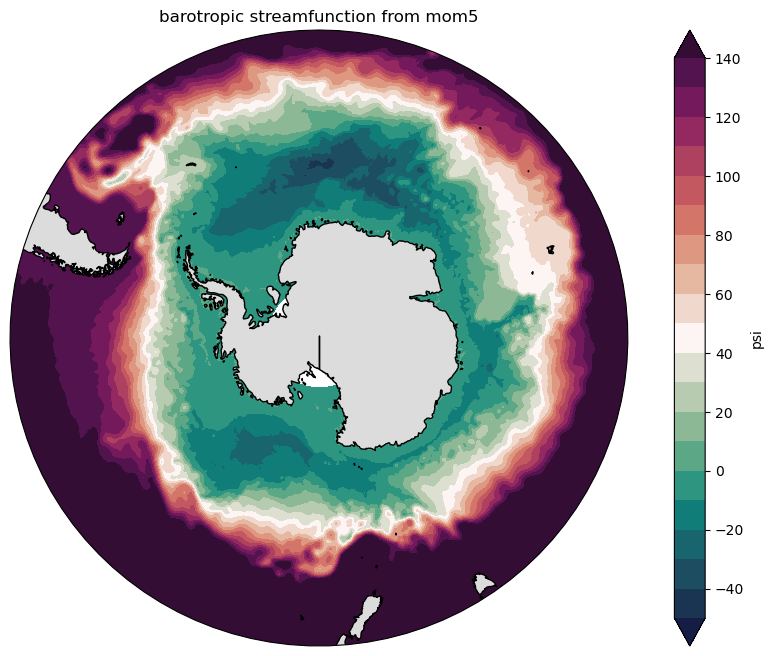

In [10]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-50, 150, 10)

# Plot the barotropic stream function
ψ_mean['mom5'].cf.plot.contourf(ax = ax,
                                x = 'longitude', y = 'latitude', 
                                transform = ccrs.PlateCarree(),
                                levels = levels, extend = 'both',
                                cmap = cmocean.cm.curl)

plt.title('barotropic streamfunction from mom5');

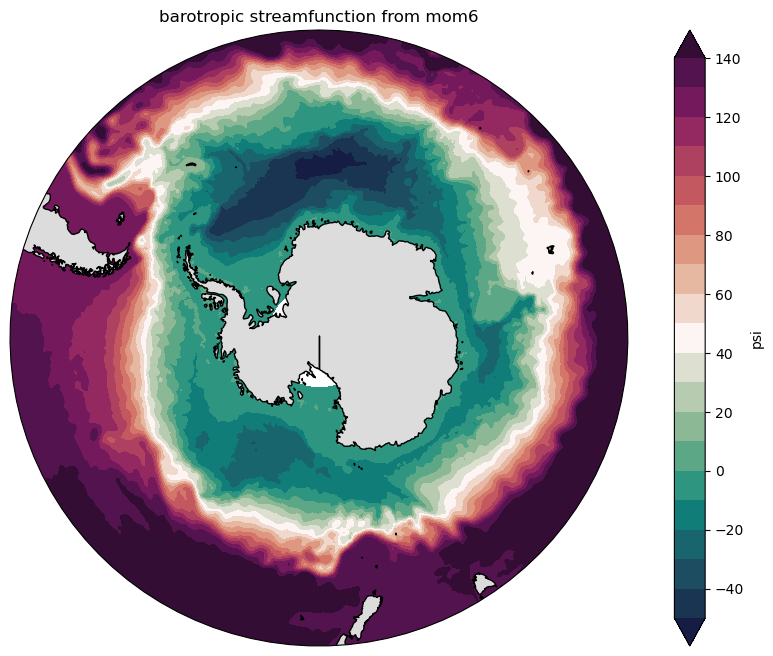

In [11]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-50, 150, 10)

# Plot the barotropic stream function
ψ_mean['mom6'].cf.plot.contourf(ax = ax,
                                x = 'longitude', y = 'latitude', 
                                transform = ccrs.PlateCarree(),
                                levels = levels, extend = 'both',
                                cmap = cmocean.cm.curl)

plt.title('barotropic streamfunction from mom6');

Load 10 years of the vertically integrated zonal transport:

In [12]:
u_int = cc.querying.getvar(model_args['mom6']['expt'], 'umo_2d', session, 
                           start_time = '2040-01-01', end_time = '2050-12-31',
                           frequency = '1 monthly')

In [13]:
print(u_int.attrs['long_name'])
print(u_int.attrs['units'])

Ocean Mass X Transport Vertical Sum
kg s-1


This is mass transport, but we want volume transport. In order to do so, divide by a reference density ($\rho_0$ = 1035 kg m$^3$)

In [14]:
u_int = u_int / RHO_0

Now, we can integrate in the meridional direction. This is the total transport in each cell, so we just need to do a cumulative sum. If it was an average value for each cell, we would need to multiply by the cell's length ($dy$).

We will divide by $10^6$ to obtain units in Sv

In [15]:
psi = u_int.cumsum('yh') / 1e6

Easy! Now we can try plotting a time-mean map

In [16]:
psi_mean = psi.mean('time')

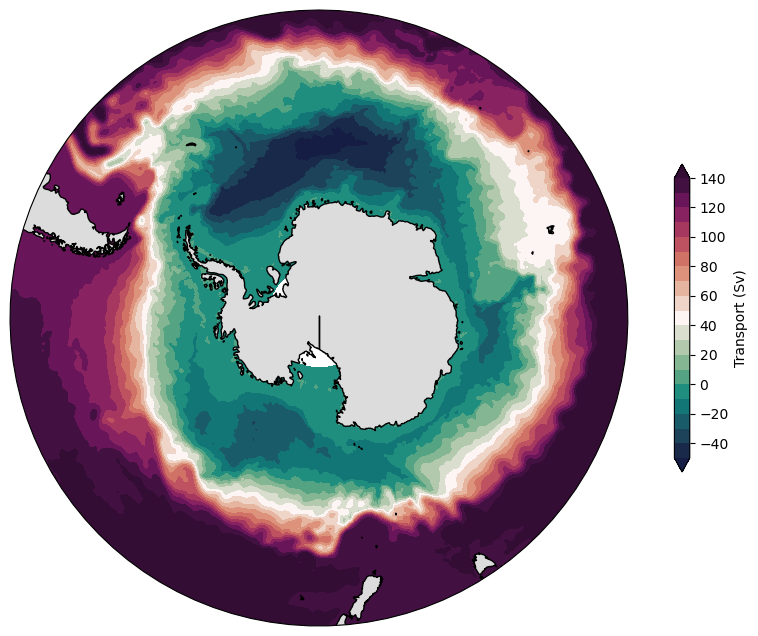

In [17]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-50, 150, 10)

# Plot the barotropic stream function
cf = ax.contourf(psi_mean['xq'], psi_mean['yh'], psi_mean,
                 levels = levels, cmap = cmocean.cm.curl, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport (Sv)')

A problem with the above map is that the diverging colormap is not centered in zero, which makes it a bit deceptive. We can shift the colorbar to fix this:

In [18]:
shifted_cmap = shift_colormap(cmocean.cm.curl, -60, 190, 'psi')

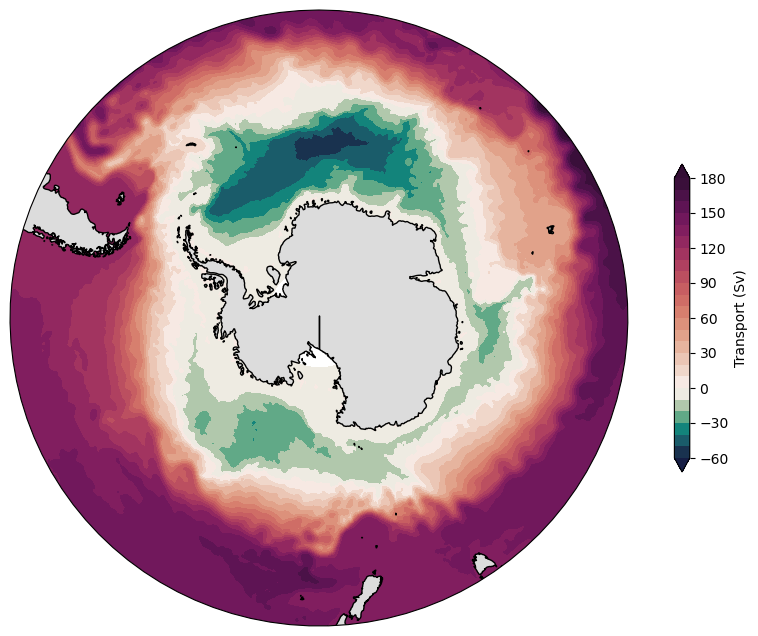

In [19]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-60, 190, 10)

# Plot the barotropic stream function
cf = ax.contourf(psi_mean['xq'], psi_mean['yh'], psi_mean,
                 levels = levels, cmap = shifted_cmap, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport (Sv)')

Much better. Now visualize its easier to understand the divide between Ross and Weddell Gyres and the ACC.

### Density coordinates

We need to load different variables now: zonal transport in density layers, and the thickness of the density layers.

In [21]:
umo = cc.querying.getvar(model_args['mom6']['expt'], 'umo', session, 
                         start_time = '2040-01-01', end_time = '2050-12-31',
                         frequency = '1 monthly')

hmo = cc.querying.getvar(model_args['mom6']['expt'], 'hmo', session,
                         start_time = '2040-01-01', end_time = '2050-12-31',
                         frequency = '1 monthly')

In [22]:
print(umo.attrs['long_name'])
print(umo.attrs['units'])

Ocean Mass X Transport
kg s-1


In [23]:
print(hmo.attrs['long_name'])
print(hmo.attrs['units'])

Layer Thickness
m


Convert to volume transport:

In [24]:
umo = umo / RHO_0

We can calculate it for the 79 layers, but since this is an example to keep it simple and fast, we will divide the ocean in two layers. The dividing density is $\rho = 1037.15$

In [26]:
rho_div = 1037.15

Average in time now, because this dataset is a bit bigger than the vertically-integrated one.

In [27]:
umo = umo.mean('time')
hmo = hmo.mean('time')

Build the streamfunction

In [28]:
psi = umo.cumsum('yh') / 1e6

Separate in upper and lower layer. Again, because each cell has the integrated value, we just need to sum in density space (no need to weight by cell thickness).

In [29]:
psi_upper = psi.sel(rho2_l = slice(None, rho_div)).sum('rho2_l')

Calculate the thickness of the upper layer:

In [30]:
hmo_upper = hmo.sel(rho2_l = slice(None, rho_div)).sum('rho2_l')

Load into memory for faster plotting!

In [31]:
psi_upper = psi_upper.load()

In [32]:
shifted_cmap = shift_colormap(cmocean.cm.curl, -60, 190, 'psi')

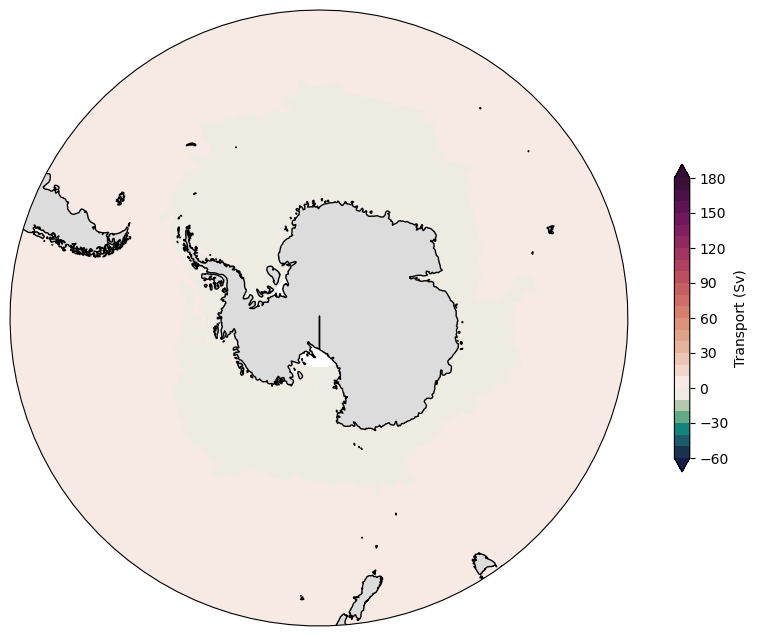

In [33]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-60, 190, 10)

# Plot the barotropic stream function
cf = ax.contourf(psi_upper['xq'], psi_upper['yh'], psi_upper,
                 levels = levels, cmap = shifted_cmap, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport (Sv)')

In [34]:
hmo_upper = hmo_upper.load()

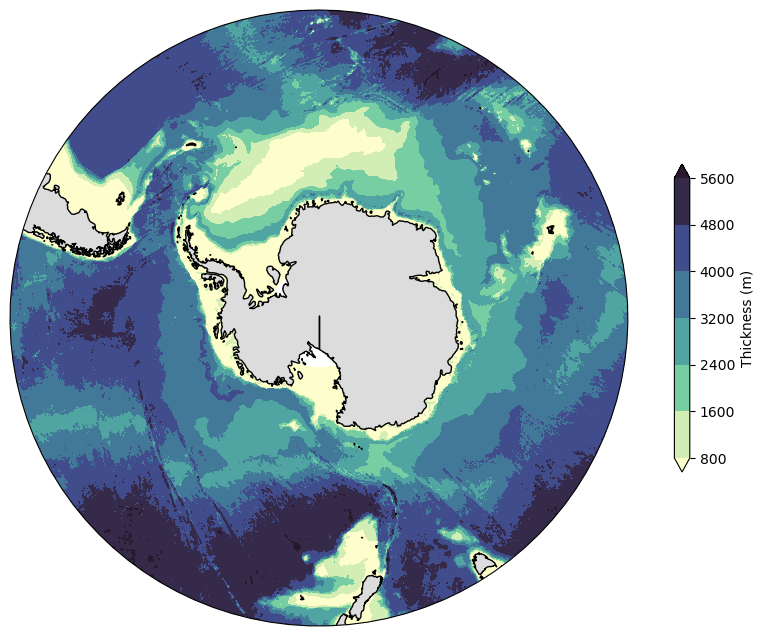

In [35]:
fig, ax = circumpolar_map()

# Plot the barotropic stream function
cf = ax.contourf(hmo_upper['xh'], hmo_upper['yh'], hmo_upper,
                 cmap = cmocean.cm.deep, extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Thickness (m)')

Now same for the lower layer:

In [36]:
psi_lower = psi.sel(rho2_l = slice(rho_div, None)).sum('rho2_l')
hmo_lower = hmo.sel(rho2_l = slice(rho_div, None)).sum('rho2_l')

In [37]:
psi_lower = psi_lower.load()

In [38]:
shifted_cmap = shift_colormap(cmocean.cm.curl, -30, 16, 'psi')

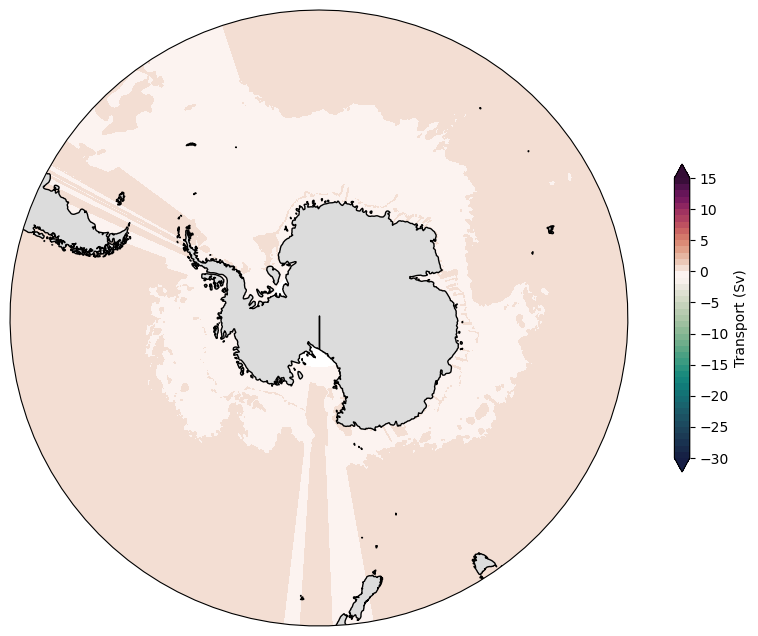

In [39]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-30, 16, 1)

# Plot the barotropic stream function
cf = ax.contourf(psi_lower['xq'], psi_lower['yh'], psi_lower,
                 levels = levels, cmap = shifted_cmap, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport (Sv)')

In [40]:
hmo_lower = hmo_lower.load()

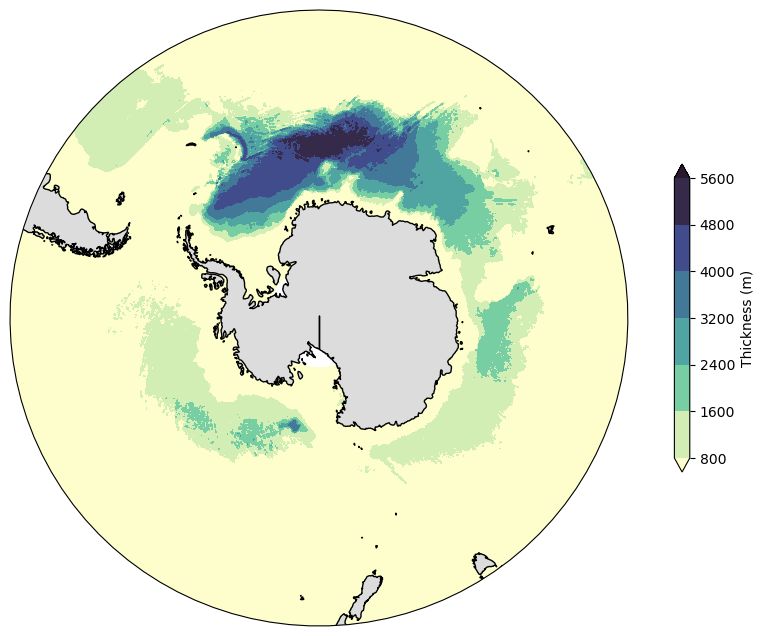

In [41]:
fig, ax = circumpolar_map()

# Plot the barotropic stream function
cf = ax.contourf(hmo_lower['xh'], hmo_lower['yh'], hmo_lower,
                 cmap = cmocean.cm.deep, extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Thickness (m)')

Lets try a cross-section. For that we need to stack our layers:

In [42]:
depth = np.stack([0*hmo_upper.sel(xh = 0, method = 'nearest'),
                    hmo_upper.sel(xh = 0, method = 'nearest'),
                  (hmo_upper+hmo_lower).sel(xh = 0, method = 'nearest')])
psi_layers = np.stack([psi_upper.sel(xq = 0, method = 'nearest'),
                       psi_lower.sel(xq = 0, method = 'nearest')])

Text(0.5, 0, 'Latitude')

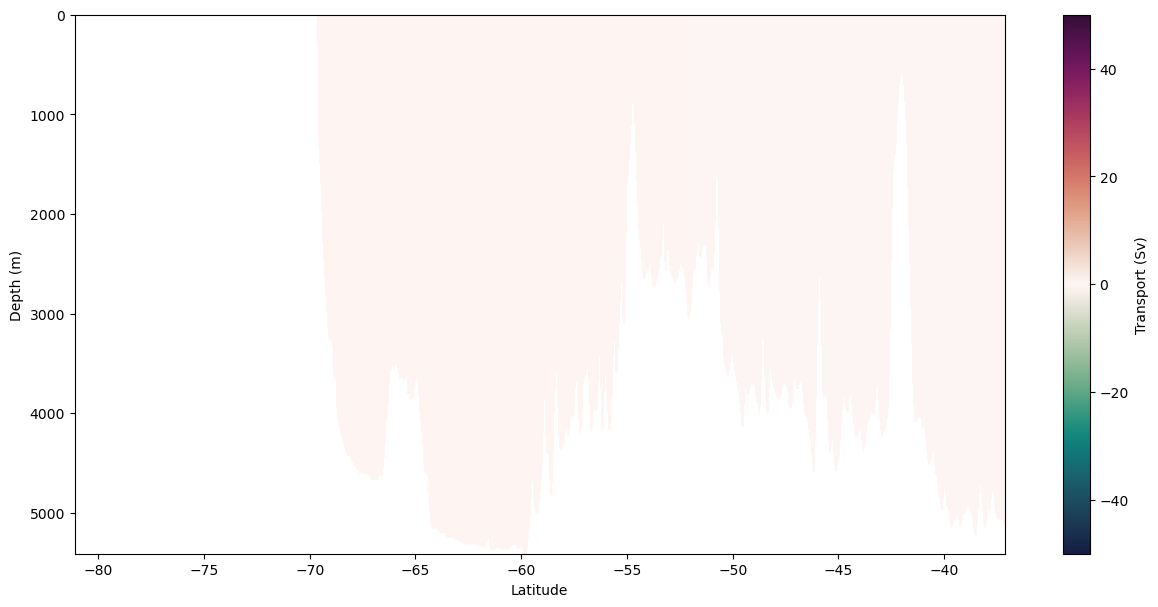

In [43]:
plt.figure(figsize = (15, 7))
plt.pcolor(psi_upper['yh'], depth, psi_layers[:, 1:], 
           shading = 'flat', vmin = -50, vmax = 50, cmap=cmocean.cm.curl)
plt.gca().invert_yaxis()
plt.colorbar().set_label('Transport (Sv)')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

### Depth coordinates

In [45]:
uo = cc.querying.getvar(model_args['mom6']['expt'], 'uo', session, 
                        start_time = '2040-01-01', end_time = '2050-12-31',
                        frequency = '1 monthly')

In [46]:
print(uo.attrs['long_name'])
print(uo.attrs['units'])

Sea Water X Velocity
m s-1


For this one, we need to load cell dimensions because the variable uo, in depth coordinates, is an average velocity of the cell. Multiplied by cell's area, it becomes a transport.

Load grid:

In [47]:
grid = xr.open_dataset(glob.glob('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-v13/output078/*ocean_static.nc')[0])

We multiply by the area of the $u$-face (i.e., by $\Delta y\,\Delta z$) to obtain the transport across that face:

In [48]:
dy = grid['dyCu']
dz = uo['z_l'].diff('z_l')

In [50]:
umo = uo.mean('time').isel(z_l = slice(None, -1)) * dy * dz
umo = umo.load()

In [51]:
psi = umo.cumsum('yh') / 1e6

We can plot now different layers! Lets try the upper 1000m

In [52]:
psi_upper = psi.sel(z_l = slice(None, 1000)).sum('z_l')

psi_upper = psi_upper.load()

In [53]:
shifted_cmap = shift_colormap(cmocean.cm.curl, -50, 130, 'psi')

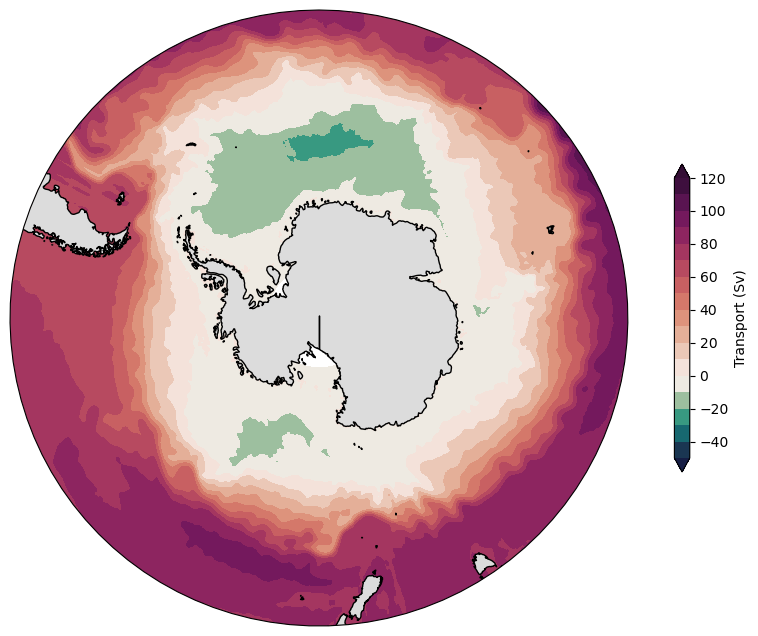

In [54]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-50, 130, 10)

# Plot the barotropic stream function
cf = ax.contourf(psi_upper['xq'], psi_upper['yh'], psi_upper,
                 levels = levels, cmap = shifted_cmap, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport (Sv)')

In [55]:
psi_lower = psi.sel(z_l = slice(1000, None)).sum('z_l')

psi_lower = psi_lower.load()

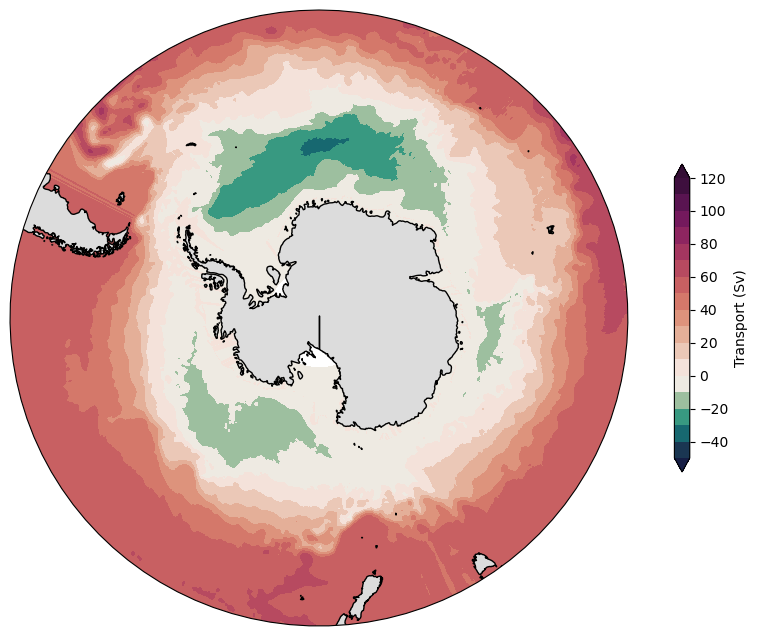

In [56]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-50, 130, 10)

# Plot the barotropic stream function
cf = ax.contourf(psi_lower['xq'], psi_lower['yh'], psi_lower,
                 levels = levels, cmap = shifted_cmap, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport (Sv)')

We can even try cross-sections!

In [57]:
psi_0 = psi.sel(xq = 0, method = 'nearest')

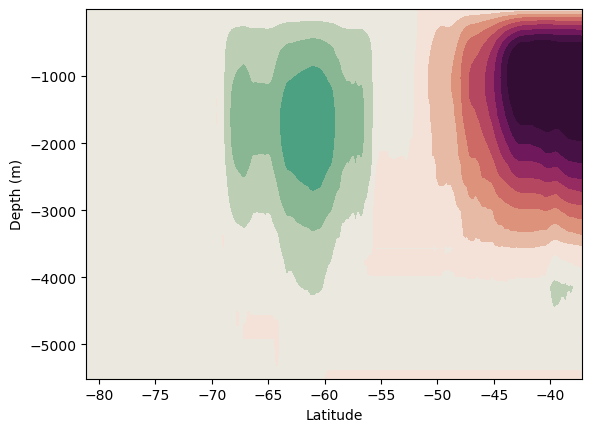

In [58]:
plt.contourf(psi_0['yh'], -psi_0['z_l'], psi_0, 
             levels = np.arange(-4, 4.5, 0.5), extend = 'both',
             cmap = cmocean.cm.curl)

plt.xlabel('Latitude')
plt.ylabel('Depth (m)');